In [1]:
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.table import Table, Column, MaskedColumn, join
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

In [2]:
HR_grid = (-0.6, 1.25, 0.002, 10, 15, 0.01)
model = WD_models.load_model('be', 'be', 'o', 'H', HR_grid=HR_grid)

# interpolate the desired mapping
mass_color = WD_models.interp_xy_z_func(x=model['mass_array'],
                                        y=model['color'],
                                        z=model['Mag'],
                                        interp_type='linear')

please check the model names.


In [3]:
print(model['grid_HR_to_mass'])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


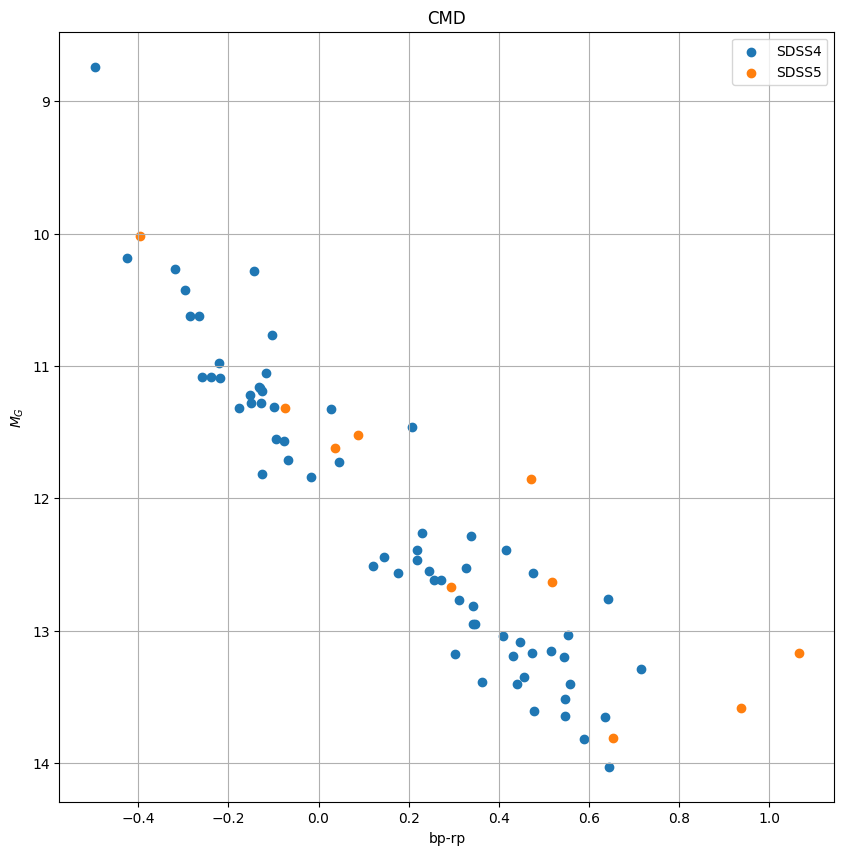

In [131]:
c1 = Table.read('data/03_wd_rv.fits')
c2 = Table.read('data/02_photometry.fits')

c15 = Table.read('data/sdss5/sdss5_catalog_photo.fits')
c25 = Table.read('data/sdss5/sdss5_catalog_rvs.fits')

plt.figure(figsize=(10,10))

plt.scatter(c1['wd_bp_rp'], c1['wd_m_g'], label='SDSS4')
plt.scatter(c25['wd_bp_rp'], c25['wd_m_g'], label='SDSS5')

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

catalog = join(c1, c2, keys='wd_source_id', join_type='inner')
catalog['program'] = [4 for i in range(len(catalog))]

catalog2 = join(c15, c25, keys='wd_source_id', join_type='inner')
catalog2['program'] = [5 for i in range(len(catalog2))]

#catalog2.remove_columns(['wd_pos_1_1','wd_pos_1_2', 'wd_pos_2_1','wd_pos_2_2'])
#catalog = vstack([catalog, catalog2])

In [132]:
print(len(catalog))

66


In [133]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_9510/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_9510/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_9510/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


Text(0.5, 0, 'E(B-V)')

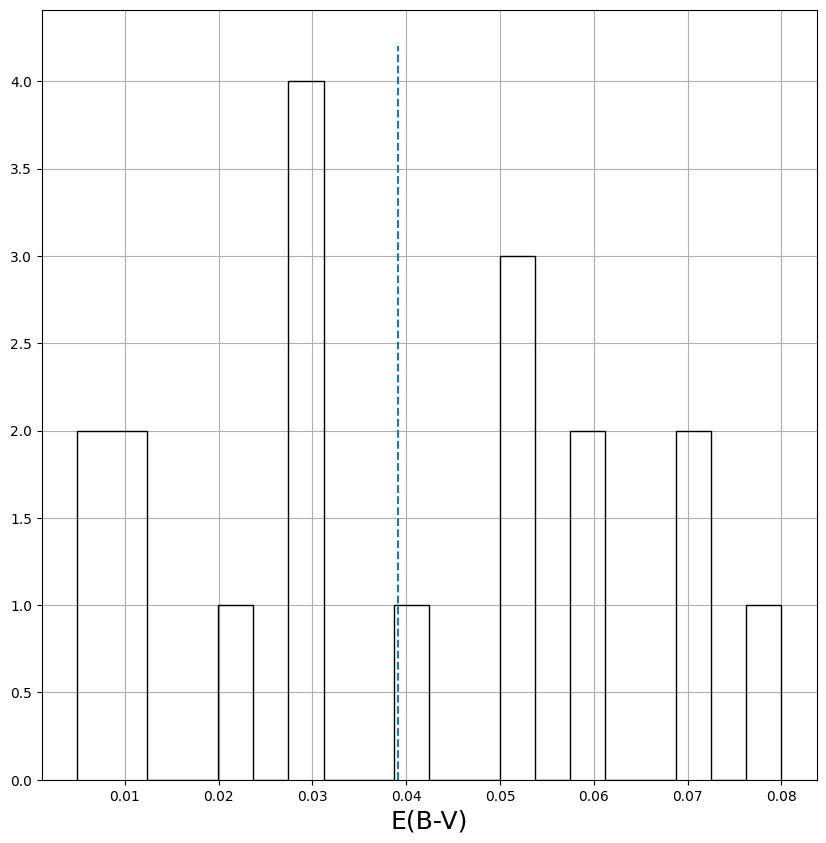

In [134]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog[catalog['E(B-V)'] != 0]['E(B-V)'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog[catalog['E(B-V)'] != 0]['E(B-V)']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'E(B-V)', fontsize=18)
#plt.xlim(0, 0.004)

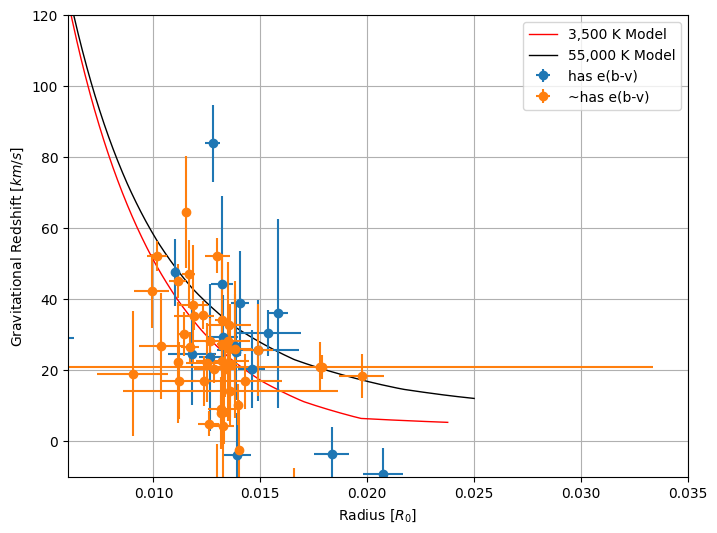

In [135]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog[catalog['E(B-V)'] != 0]['radius'], catalog[catalog['E(B-V)'] != 0]['g_redshift'], 
             xerr = catalog[catalog['E(B-V)'] != 0]['e_radius'], yerr=catalog[catalog['E(B-V)'] != 0]['eg_redshift'], fmt='o', label='has e(b-v)')
plt.errorbar(catalog[catalog['E(B-V)'] == 0]['radius'], catalog[catalog['E(B-V)'] == 0]['g_redshift'], 
             xerr = catalog[catalog['E(B-V)'] == 0]['e_radius'], yerr=catalog[catalog['E(B-V)'] == 0]['eg_redshift'], fmt='o', label='~has e(b-v)')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.035)
plt.ylim(-10, 120)
plt.legend()

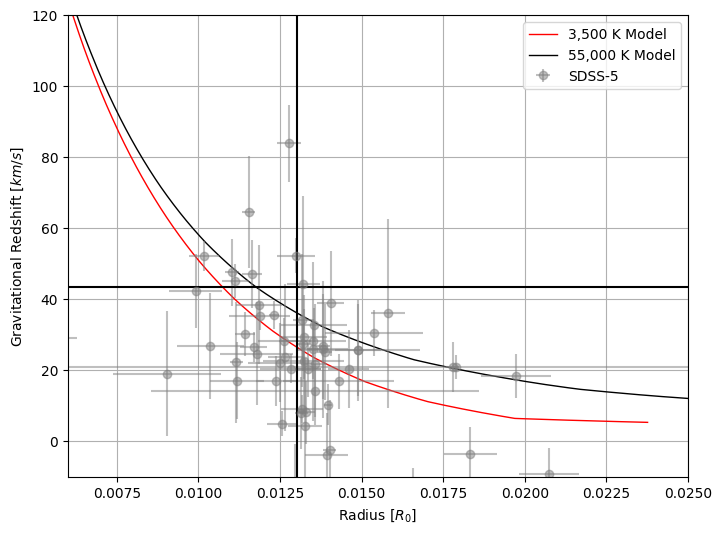

In [136]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

xy = np.vstack([catalog['radius'],catalog['g_redshift']])
z = gaussian_kde(xy)(xy)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

"""
plt.errorbar(catalog[catalog['program'] == 4]['radius'], catalog[catalog['program'] == 4]['g_redshift'], 
             xerr = catalog[catalog['program'] == 4]['e_radius'], yerr=catalog[catalog['program'] == 4]['eg_redshift'], 
             fmt='o', label = 'SDSS-4', alpha = 0.5)
plt.errorbar(catalog[catalog['program'] == 5]['radius'], catalog[catalog['program'] == 5]['g_redshift'], 
             xerr = catalog[catalog['program'] == 5]['e_radius'], yerr=catalog[catalog['program'] == 5]['eg_redshift'], 
             fmt='o', label = 'SDSS-5', alpha = 0.5)
"""

plt.errorbar(catalog['radius'], catalog['g_redshift'], 
             xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], 
             fmt='o', label = 'SDSS-5', alpha = 0.5, color = 'grey')

plt.hlines(np.mean(catalog['g_redshift']), 0.006, 0.025, colors='black')
plt.vlines(np.mean(catalog['radius']), -10, 120, colors='black')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(-10, 120)
plt.legend()
#plt.savefig('plots/photometry/gredshift_vs_radius.jpg')

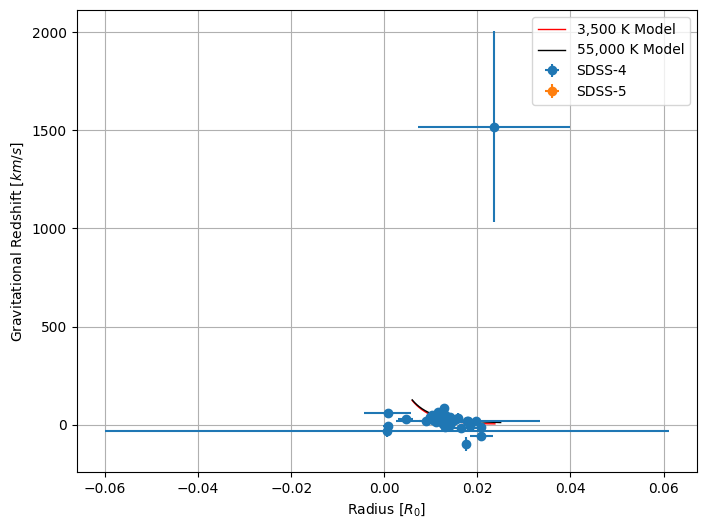

In [137]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog[catalog['program'] == 4]['radius'], catalog[catalog['program'] == 4]['g_redshift'], 
             xerr = catalog[catalog['program'] == 4]['e_radius'], yerr=catalog[catalog['program'] == 4]['eg_redshift'], fmt='o', label = 'SDSS-4')
plt.errorbar(catalog[catalog['program'] == 5]['radius'], catalog[catalog['program'] == 5]['g_redshift'], 
             xerr = catalog[catalog['program'] == 5]['e_radius'], yerr=catalog[catalog['program'] == 5]['eg_redshift'], fmt='o', label = 'SDSS-5')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.035)
#plt.ylim(-10, 120)
plt.legend()

In [138]:
#catalog[['wd_coords', 'clean', 'insideMask', 'converged', 'reliable_dist']].pprint(100,100)

np.all([catalog['program'] == 5], axis = 0)
clean = np.logical_or(catalog['clean'], np.all([catalog['program'] == 5], axis = 0))

Text(0.5, 0, '$RV_{MS} - RV_{WD}$ $[km/s]$')

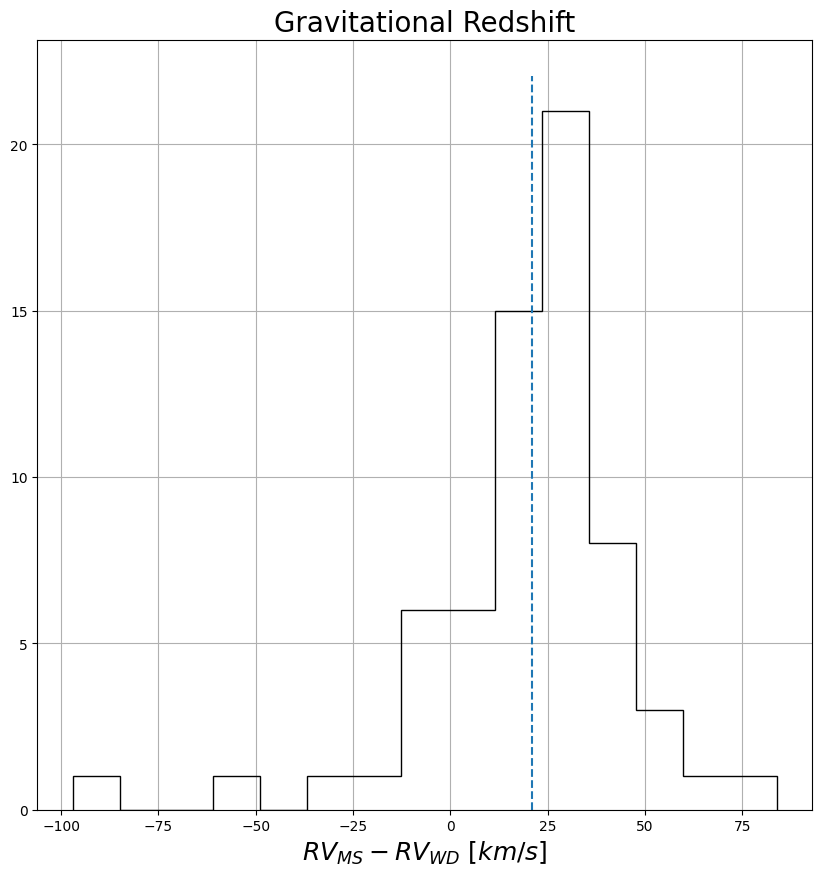

In [139]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog[catalog['g_redshift'] < 1000]['g_redshift'], bins = 15, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog[catalog['g_redshift'] < 1000]['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$ $[km/s]$', fontsize=18)

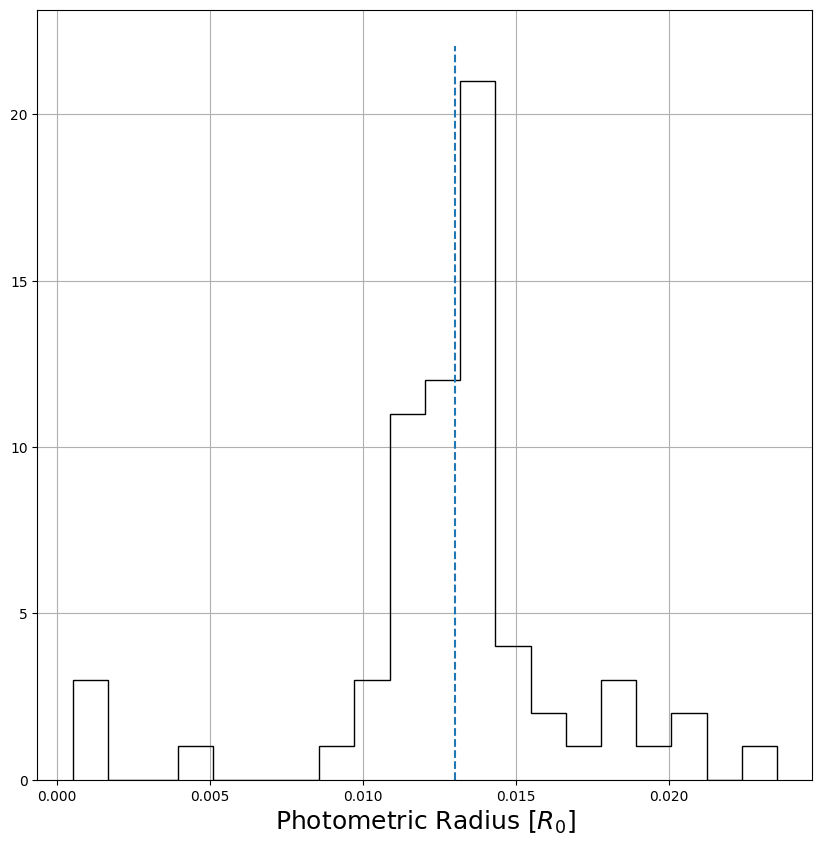

In [140]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)
plt.savefig('plots/photometry/cleaned_radius.png')

In [141]:
rechi = np.all([catalog['rechi'] < 5], axis = 0)
redchi = np.all([catalog['redchi'] < 5], axis = 0)

teff_mask = np.ones(len(catalog))
for i in tqdm(range(len(teff_mask))):
    if catalog['corv_teff'][i] != catalog['phot_teff_1'][i]:
        teff_mask[i] = 0
        
teff_mask = teff_mask.astype(bool)

100%|███████████████████████████████████████████████████████████████████████| 66/66 [00:00<00:00, 299917.73it/s]


In [142]:
mask = np.all([redchi, rechi, clean], axis = 0)
mask1 = np.all([clean], axis = 0)

#mask = np.all([clean, photomask, redchi_mask, rechi_mask, e_redshift_mask], axis = 0)
#mask = np.all([clean, photomask], axis = 0)
#mask = np.all([clean, radius_mask, redshift_mask], axis = 0)
#mask = np.all([clean, photomask, redchi_mask, rechi_mask, radius_mask, redshift_mask], axis = 0)
print(mask)
print(mask1)

[ True False  True False False  True  True  True False False False  True
  True  True False False  True  True False  True False False  True False
  True  True  True  True  True  True False  True False  True False  True
  True  True  True False False  True False False False  True  True False
  True  True  True False False  True False False False False False False
  True False False  True  True False]
[ True  True  True False False  True  True  True False False False  True
  True  True  True False  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True False False  True False  True  True  True  True False
  True False False  True  True False]


24.99793486985869
wd_catalog_id rv_id        radius               e_radius             g_redshift        eg_redshift             redchi              rechi            corv_teff      program
------------- ----- -------------------- ---------------------- ------------------- ------------------ --------------------- ------------------ ------------------ -------
           82   0.0 0.011880705408930893  0.0009312900305083172  35.408425832536864 3.9307448600855253 0.0006801296580085979  1.162559849441431  8830.334172987781       4
          108   2.0  0.01401605680547447  0.0002027534268423504 -2.4002709981288533 14.047824642327651   0.19667745655958038 1.1440252802174562 17461.173879560367       4
           18   5.0 0.011433860642687277  0.0002994424857915555  30.334750505657595  6.197316145552023    1.4118771597616908 1.1928155984088873  7036.527661025797       4
           17   6.0  0.01351412570592664 0.00019333544394583137   25.97933969581701  8.518015251457399    0.8848032690146695 0.

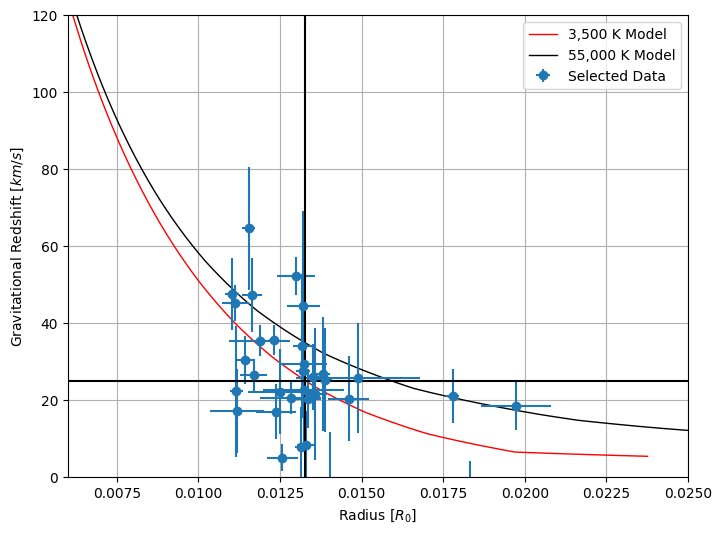

In [143]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.hlines(np.mean(catalog['g_redshift'][mask]), 0.006, 0.025, colors='black')
plt.vlines(np.mean(catalog['radius'][mask]), -10, 120, colors='black')

print(np.mean(catalog['g_redshift'][mask]))

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

catalog[['wd_catalog_id', 'rv_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi', 'rechi', 'corv_teff', 'program']][mask].pprint(100, 200)
#catalog[['wd_catalog_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi', 'rechi', 'program']][~mask].pprint(100, 200)

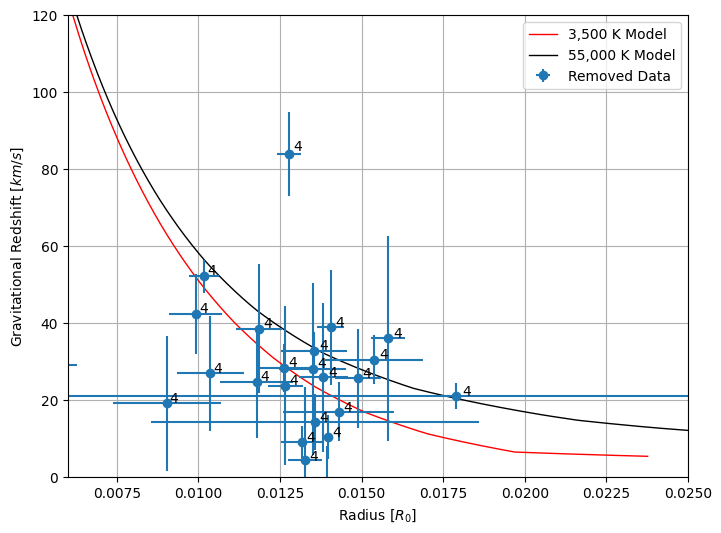

In [144]:
from scipy.optimize import curve_fit

def exp(x, A, B, C):
    return A*x**B+C

#popt, pcov = curve_fit(exp, catalog['radius'][mask], catalog['g_redshift'][mask], 
#                       sigma = catalog['eg_redshift'][mask], p0 = [1, 1, 1])

#print(popt)

plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Removed Data')

for i in range(len(catalog['radius'][~mask])):
    x = catalog['radius'][~mask][i]
    y = catalog['g_redshift'][~mask][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) ,  str(catalog['program'][~mask][i]), fontsize=10)
    
    #plt.text(x * (1 + 0.01), y * (1 + 0.01) ,  str(catalog['program'][mask][i]), fontsize=10)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

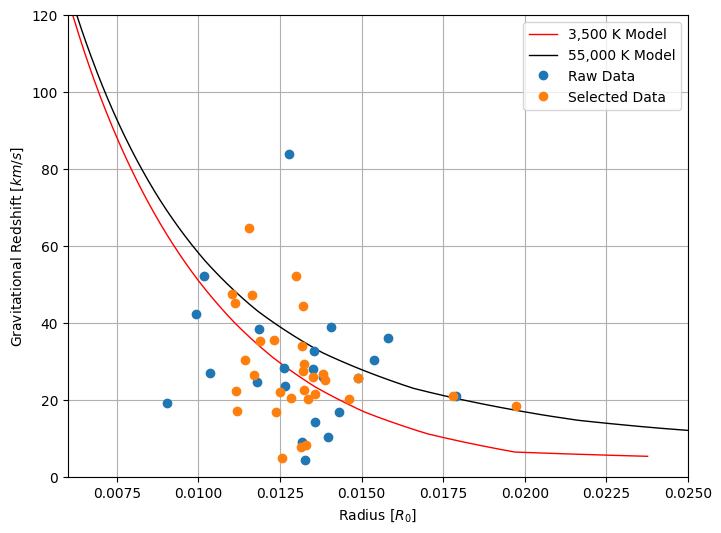

In [145]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

In [104]:
#catalog = catalog[mask == 1]
print(len(catalog))

66


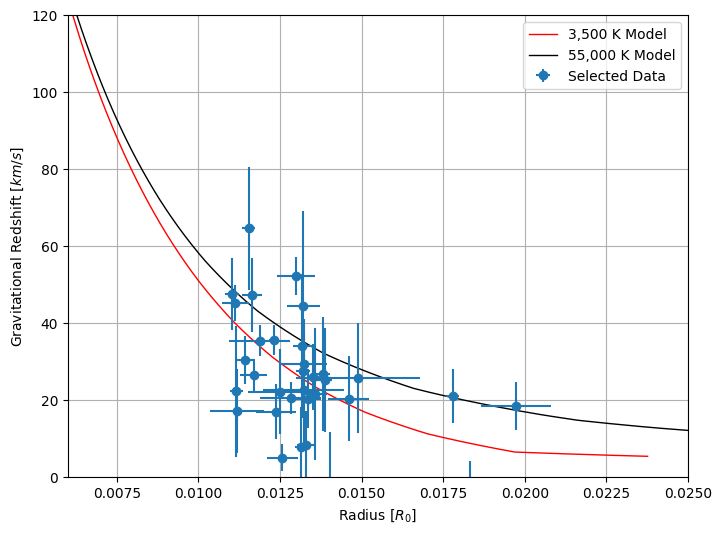

In [105]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

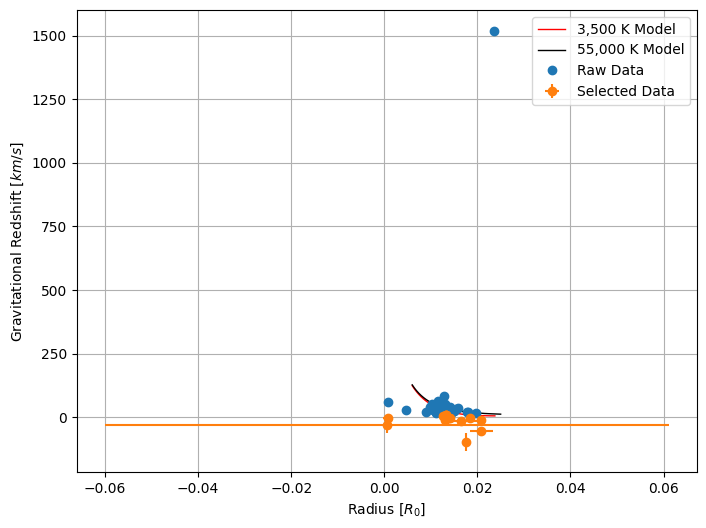

In [106]:
investigative = np.all([catalog['g_redshift'] < 10], axis = 0)

plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~investigative], catalog['g_redshift'][~investigative], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][investigative], catalog['g_redshift'][investigative], xerr = catalog['e_radius'][investigative], yerr=catalog['eg_redshift'][investigative], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(0, 120)
plt.legend()

In [107]:
print(catalog[['wd_catalog_id', 'rv','g_redshift', 'radius', 'R_chance_align']][np.logical_and(investigative, mask)])

wd_catalog_id          rv              g_redshift            radius            R_chance_align    
------------- ------------------- ------------------- -------------------- ----------------------
          108 -22.302597581991158 -2.4002709981288533  0.01401605680547447     0.0006199301301292
            3  -10.60940620613748 -11.508235427862944 0.012950660832499314      0.035244081871421
           83 0.22216507876043373   4.977360696436215 0.012575323301880579  7.300629160959902e-06
           36  22.151744119935344  -3.680599935240437 0.018335127360932835     0.0001374949264793
           78   34.48742118652156    8.25664153869441 0.013299260909193322     0.0006214070251626
           99 -11.035095692712257    7.88670301334243 0.013154353531902276 1.9391449325621223e-05


In [60]:
catalog[['wd_catalog_id', 'rv','g_redshift', 'radius', 'R_chance_align']][mask].pprint(100, 100)

'''
radii: 23, 30, 31, 63, 68, 74, 83
corv: 59
'''

oldmask = mask.copy()

badstars = [23, 30, 31, 63, 68, 74, 83, 59]

for i in range(len(mask)):
    if (mask[i] != 0) and (catalog['wd_catalog_id'][i] in badstars):
        mask[i] = 0

wd_catalog_id          rv              g_redshift            radius            R_chance_align    
------------- ------------------- ------------------- -------------------- ----------------------
           82   58.77424194886987  35.408425832536864 0.011880705408930893  7.591392913432326e-05
          108 -22.302597581991158 -2.4002709981288533  0.01401605680547447     0.0006199301301292
           18   54.55969366666834  30.334750505657595 0.011433860642687277  3.952209660670122e-07
           17   50.03514680946447   25.97933969581701  0.01351412570592664 1.8647269808828277e-05
           19     97.724190426863   64.55148763755636 0.011536172290105054     0.0016200695317953
          105   51.76277296133633   38.44511262961026 0.011858792297188432     0.0003206385028749
            3  -10.60940620613748 -11.508235427862944 0.012950660832499314      0.035244081871421
           51   45.53751799429901  45.133437513961866 0.011131156869991962  4.181233891997112e-06
          114   49.0

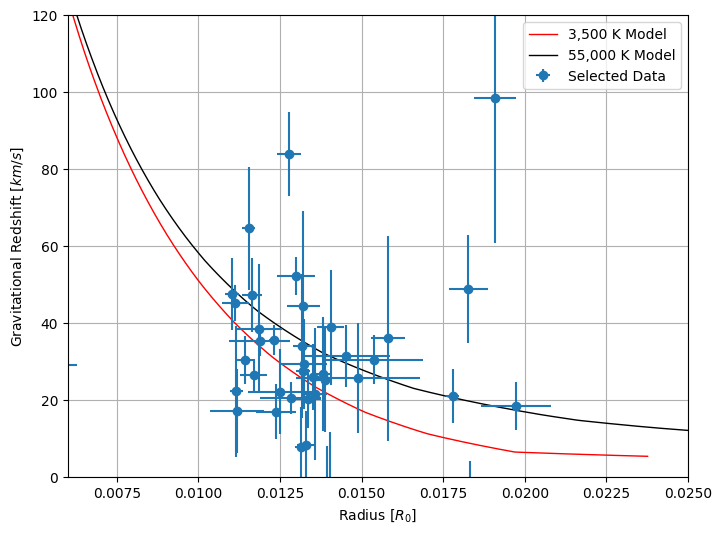

In [61]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

Text(0.5, 0, '$RV_{WD} - RV_{MS}$ $[km/s]$')

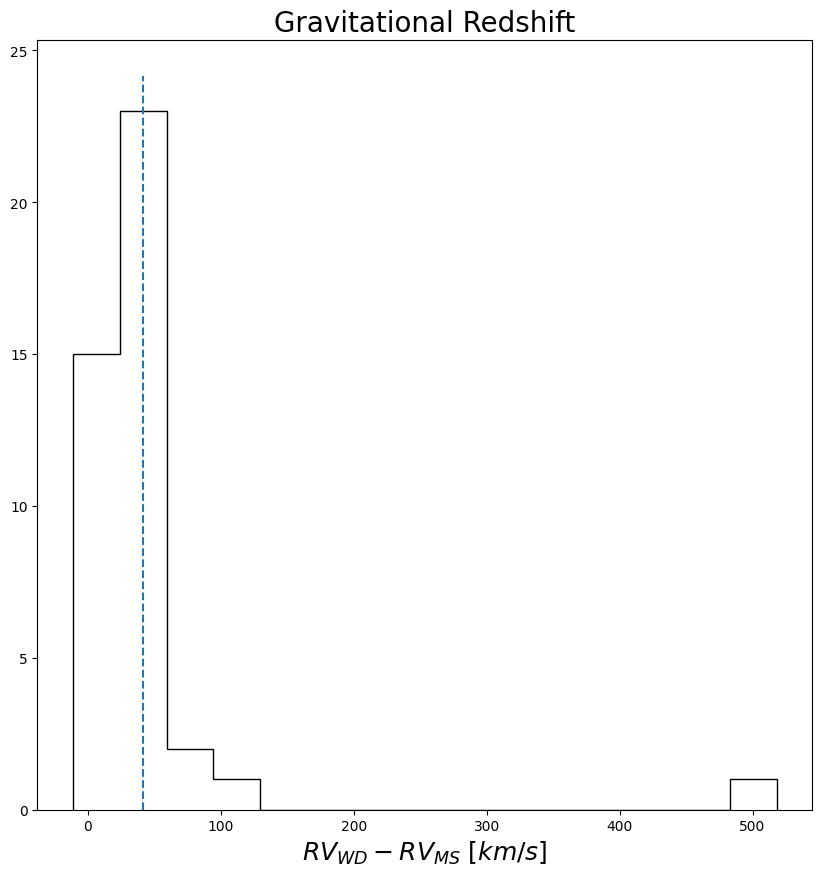

In [62]:
plt.figure(figsize=(10,10))
#plt.grid()
plt.hist(catalog['g_redshift'][mask], bins = 15, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['g_redshift'][mask]), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{WD} - RV_{MS}$ $[km/s]$', fontsize=18)

In [63]:
catalog[['wd_catalog_id', 'rv','g_redshift', 'radius', 'R_chance_align']][mask].pprint(100, 100)


wd_catalog_id          rv              g_redshift            radius            R_chance_align    
------------- ------------------- ------------------- -------------------- ----------------------
           82   58.77424194886987  35.408425832536864 0.011880705408930893  7.591392913432326e-05
          108 -22.302597581991158 -2.4002709981288533  0.01401605680547447     0.0006199301301292
           18   54.55969366666834  30.334750505657595 0.011433860642687277  3.952209660670122e-07
           17   50.03514680946447   25.97933969581701  0.01351412570592664 1.8647269808828277e-05
           19     97.724190426863   64.55148763755636 0.011536172290105054     0.0016200695317953
          105   51.76277296133633   38.44511262961026 0.011858792297188432     0.0003206385028749
            3  -10.60940620613748 -11.508235427862944 0.012950660832499314      0.035244081871421
           51   45.53751799429901  45.133437513961866 0.011131156869991962  4.181233891997112e-06
          114   49.0

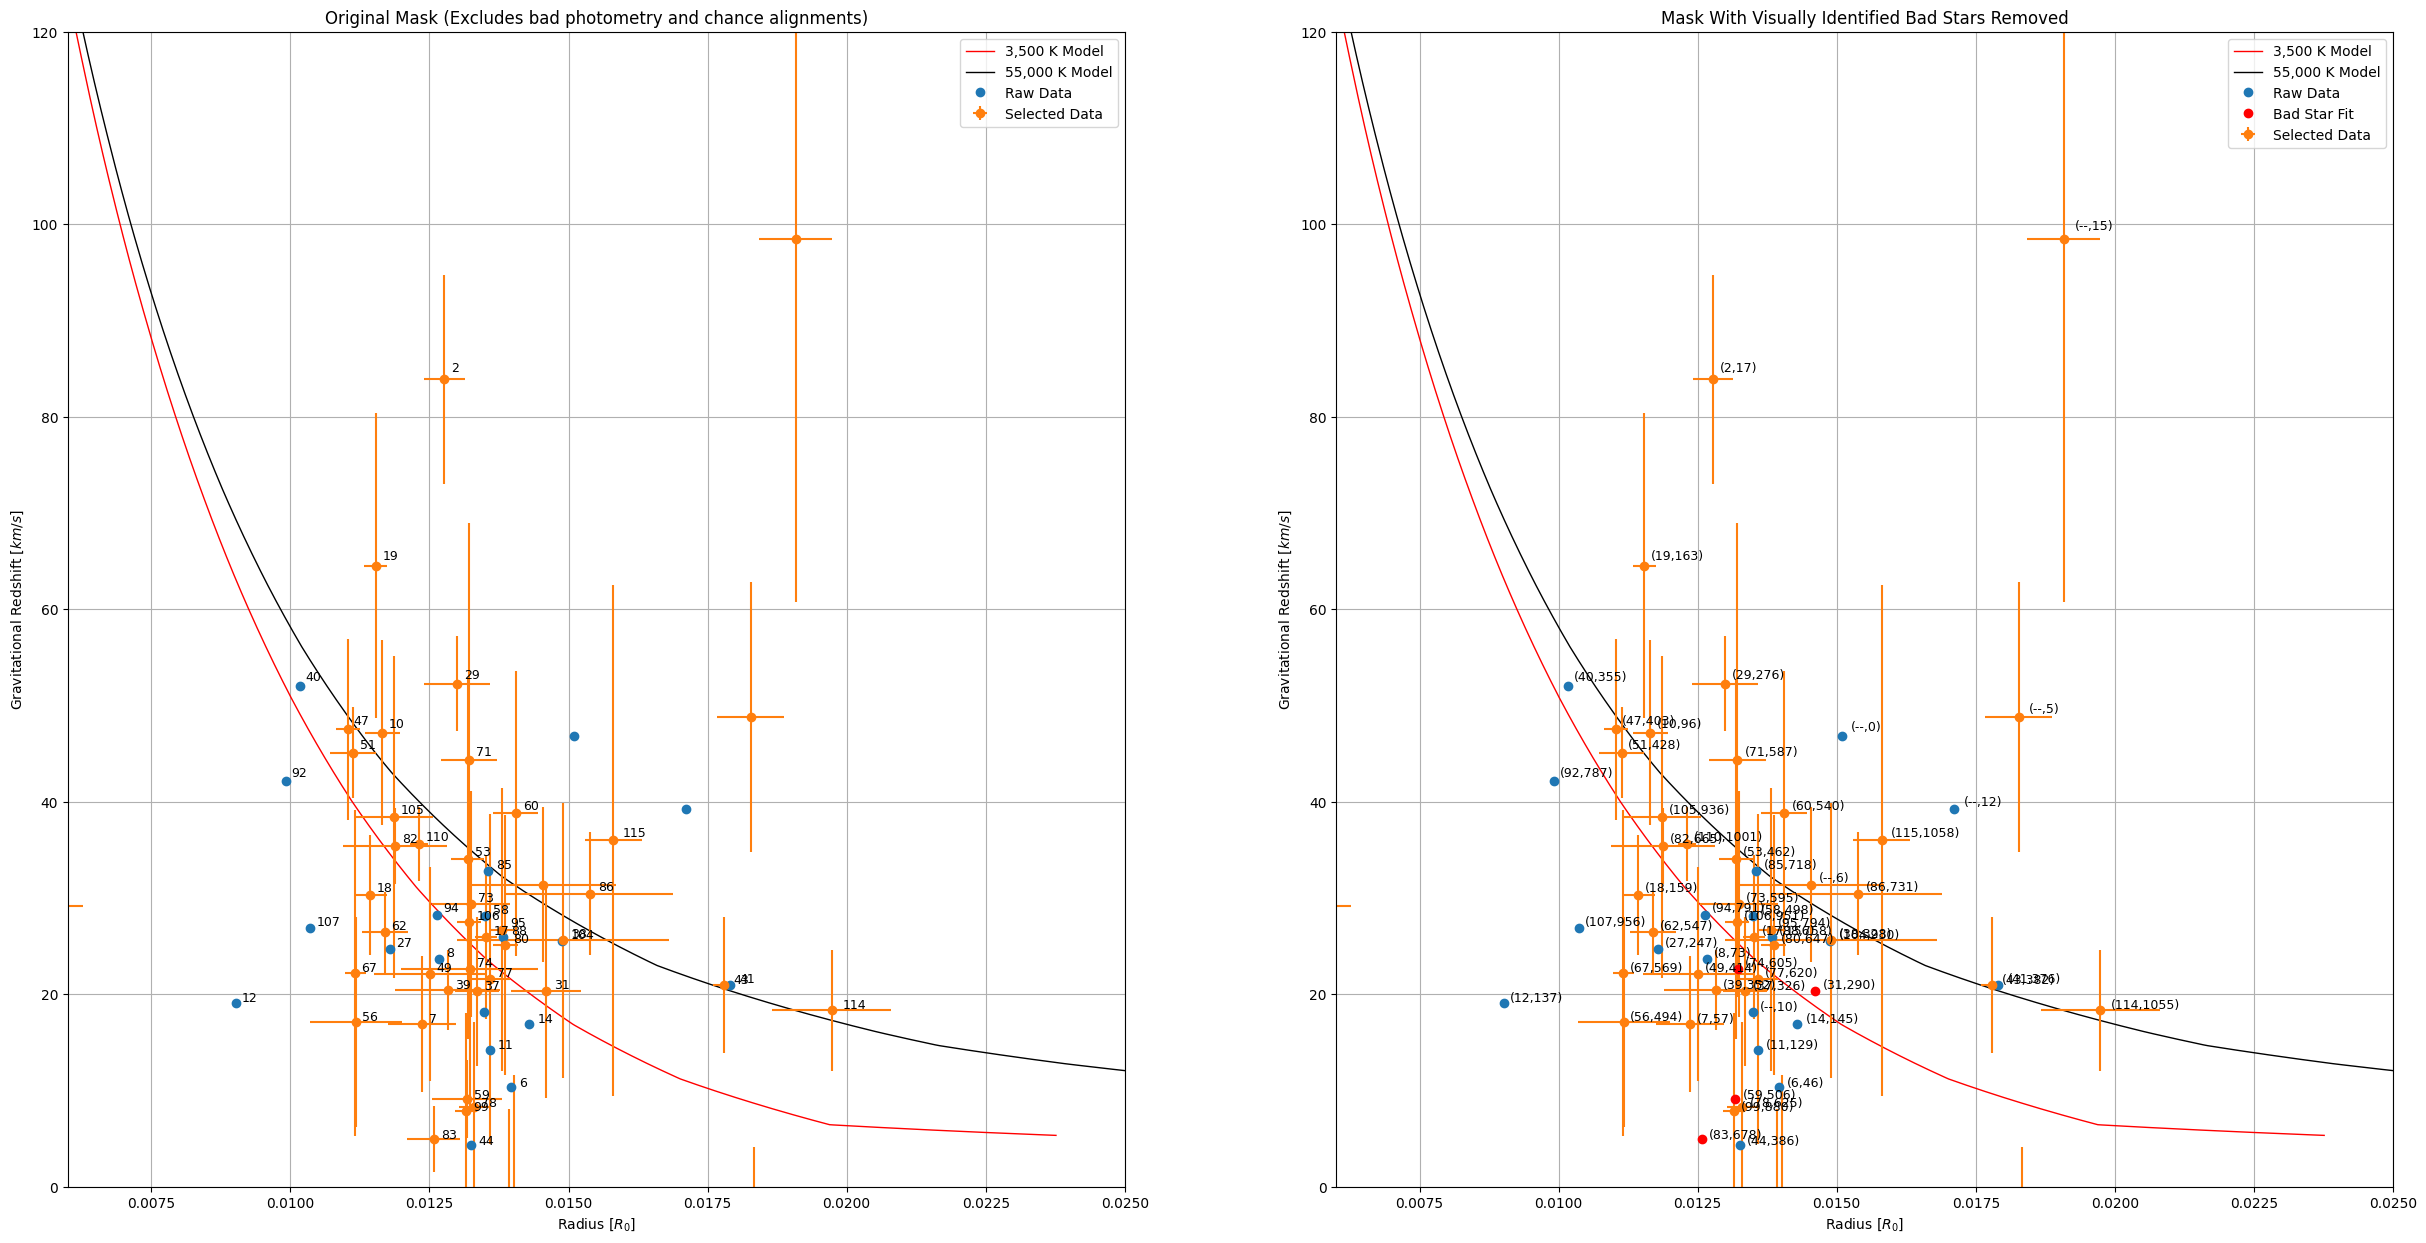

In [64]:
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][oldmask], catalog['g_redshift'][oldmask], xerr = catalog['e_radius'][oldmask], yerr=catalog['eg_redshift'][oldmask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][i], fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.title('Original Mask (Excludes bad photometry and chance alignments)')
plt.legend()

plt.subplot(1,2,2)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][np.logical_and(oldmask, ~mask)], catalog['g_redshift'][np.logical_and(oldmask, ~mask)], fmt='o', label = 'Bad Star Fit', color = 'Red')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][i]) + ',' + str(int(catalog['phot_id'][i])) + ')', fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.title('Mask With Visually Identified Bad Stars Removed')
plt.legend()

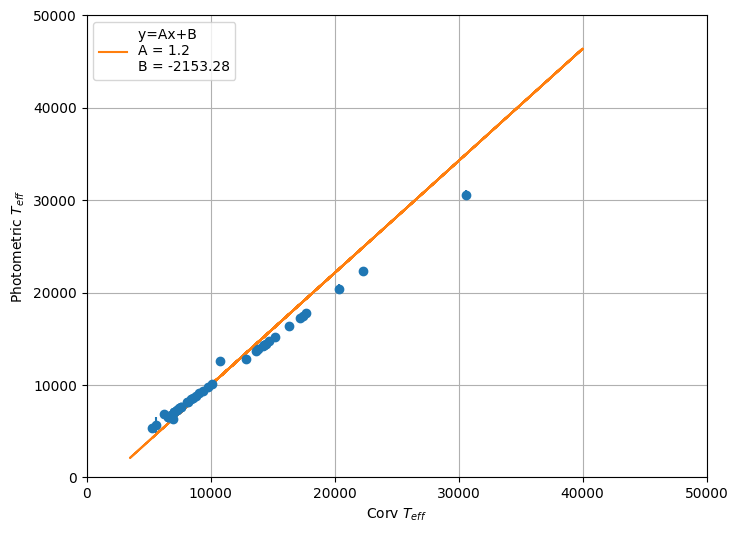

In [65]:
def linear(x, A, B):
    return A*x+B

popt, pcov = curve_fit(linear, catalog['corv_teff'][mask], catalog['phot_teff_1'][mask], sigma = catalog['e_teff'][mask])

plt.figure(figsize=(8,6))

plt.errorbar(catalog['corv_teff'][mask], catalog['phot_teff_1'][mask], xerr = catalog['e_teff'][mask], yerr=catalog['e_phot_teff_1'][mask], fmt='o')
plt.plot(catalog['corv_teff'], linear(catalog['corv_teff'], popt[0], popt[1]), label=("y=Ax+B \nA = {:2.2} \nB = {:2.2f}".format(popt[0], popt[1])))

plt.grid()
plt.xlabel(r'Corv $T_{eff}$')
plt.ylabel(r'Photometric $T_{eff}$')
plt.xlim(0, 50000)
plt.ylim(0, 50000)
plt.legend()
#plt.savefig('plots/photometry/cleaned_gredshift_vs_radius.jpg')

In [66]:
from astroquery.gaia import Gaia


ADQL_CODE1 = "SELECT source_id, grvs_mag, grvs_mag_error, grvs_mag_nb_transits, rv_template_teff, rv_template_logg, rv_template_fe_h \
    FROM gaiadr3.gaia_source \
    WHERE gaia_source.source_id IN {}\
    AND radial_velocity is not null\
    AND radial_velocity_error < 2\
".format(tuple(catalog['ms_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()



HTTPError: Error 400: 
Cannot parse query 'SELECT  TOP 2000 source_id, grvs_mag, grvs_mag_error, grvs_mag_nb_transits, rv_template_teff, rv_template_logg, rv_template_fe_h     FROM gaiadr3.gaia_source     WHERE gaia_source.source_id IN (587767172106520320, 593915842991753088, 599615715567025024, 611167253447201280, 635639049386379904, 642837139695905024, 647300091753069952, 649472486214811776, 667328520689073152, 722129653388999552, 724012227749419648, 754878680236803328, 793575098624411136, 828463697788980096, 833453629449560704, 835516068448830464, 861577620763026048, 908364387441657472, 1011166113298929664, 1204247536322459648, 1211355294880531968, 1212425463290645120, 1220062361820483840, 1245026391074834432, 1266120732108636288, 1274417234535214464, 1277405157384126592, 1311660510866758016, 1323408242853122560, 1376294820868528128, 1379988011706644096, 1392710284657089536, 1475571271928706816, 1478484737227019520, 1483533591540598016, 1508121106782208896, 1523402226760424576, 1551850062905143168, 1576983489965624320, 1902773453907469696, 2424880849616628096, 2500203890109764224, 2540555863770173696, 2544285956968663040, 2546874379138453760, 2560209183144165248, 2576762025758278656, 2608249015120878976, 2641865277470199808, 2678482381929276800, 2745245621321927552, 2854365725107598592, 3244617448738051200, 3715972517288035584, 3745063945692296576, 3803142829929703552, 3804738874137073920, 3843636017819394176, 3871381751364947712, 3897577272299564928, 3931611761384414592, 3975115244607118848, 4010863666161192576, 4032775077476714112, 4406730252080562432, 4461978959028633088, masked, masked, masked, masked, masked, masked, masked, masked, masked, masked)    AND radial_velocity is not null    AND radial_velocity_error &lt; 2' for job '1667532982328O': 10 unresolved identifiers: masked [l.1 c.1563 - l.1 c.1569], masked [l.1 c.1571 - l.1 c.1577], masked [l.1 c.1579 - l.1 c.1585], masked [l.1 c.1587 - l.1 c.1593], masked [l.1 c.1595 - l.1 c.1601], masked [l.1 c.1603 - l.1 c.1609], masked [l.1 c.1611 - l.1 c.1617], masked [l.1 c.1619 - l.1 c.1625], masked [l.1 c.1627 - l.1 c.1633], masked [l.1 c.1635 - l.1 c.1641] !


In [ ]:
grvs = []
grvs_err = []
grvs_nb_transit = []
teff = []
logg = []
fe_h = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(catalog['ms_source_id'][i] == d1['source_id'])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        grvs.append(d1['grvs_mag'][j])
        grvs_err.append(d1['grvs_mag_error'][j])
        grvs_nb_transit.append(d1['grvs_mag_nb_transits'][j])
        teff.append(d1['rv_template_teff'][j])
        logg.append(d1['rv_template_logg'][j])
        fe_h.append(d1['rv_template_fe_h'][j])
    else:
        drops.append(i)   

catalog['ms_grvs_mag'] = grvs
catalog['ms_grvs_mag_err'] = grvs_err
catalog['ms_grvs_mag_nb_transit'] = grvs_nb_transit
catalog['ms_teff'] = teff
catalog['ms_logg'] = logg
catalog['ms_fe_h'] = fe_h

In [ ]:
ms_rv_corr = []

for i in tqdm(range(len(catalog))):
    if catalog['ms_grvs_mag'][i] >= 11:
        ms_rv_corr.append(catalog['ms_rv'][i] - (0.02755 * catalog['ms_grvs_mag'][i]**2 - 0.55863 * catalog['ms_grvs_mag'][i] + 2.81129))
    else:
        ms_rv_corr.append(catalog['ms_rv'][i])
        
    
    
catalog['ms_rv_corr'] = ms_rv_corr    
    
catalog['g_redshift_corr'] = catalog['rv'] - catalog['ms_rv_corr']
catalog['eg_redshift_corr'] = catalog['ms_erv'] + catalog['e_rv']

In [ ]:
catalog[['wd_catalog_id', 'ms_phot_g_mean_mag', 'ms_grvs_mag', 'ms_rv', 'ms_rv_corr']][mask].pprint(100, 100)

In [ ]:
is_not_giant = np.ones(len(catalog))

for i in range(len(catalog)):
    if catalog['ms_m_g'][i] < (2 * catalog['ms_bp_rp'][i] + 0.5):
        is_not_giant[i] = 1
        
catalog['is_not_giant'] = is_not_giant
catalog['pairdistance_arcsec'] = catalog['pairdistance'] * 3600

In [ ]:
catalog[['wd_catalog_id', 'phot_id', 'ms_phot_g_mean_mag', 'ms_grvs_mag', 'ms_rv', 'ms_rv_corr', 'is_not_giant', 'pairdistance_arcsec']][mask].pprint(200, 200)

In [ ]:
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][np.logical_and(oldmask, ~mask)], catalog['g_redshift'][np.logical_and(oldmask, ~mask)], fmt='o', label = 'Bad Star Fit', color = 'Red')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][i], fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.title('Original Mask (Excludes bad photometry and chance alignments)')
plt.legend()

plt.subplot(1,2,2)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift_corr'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][np.logical_and(oldmask, ~mask)], catalog['g_redshift_corr'][np.logical_and(oldmask, ~mask)], fmt='o', label = 'Bad Star Fit', color = 'Red')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift_corr'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (-30 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][i]) + ',' + str(int(catalog['phot_id'][i])) + ')', fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(-30, 120)
plt.title('Mask With Visually Identified Bad Stars Removed')
plt.legend()

In [ ]:
catalog['rv_theory'] = rv_from_radius(catalog['radius'], catalog['ms_teff'], 'f', 'f', 'f')
catalog['pct_err'] = (catalog['g_redshift'] - catalog['rv_theory']) / catalog['rv_theory'] * 100

catalog[['wd_catalog_id', 'phot_id', 'g_redshift', 'radius', 'rv', 'ms_rv', 'ms_bp_rp', 'ms_teff', 'ms_logg', 'ms_fe_h', 'corv_logg', 'corv_teff']][mask].pprint(100, 200)

tempmask = mask.copy()

for i in range(len(mask)):
    if catalog['pct_err'][i] < -200:
        tempmask[i] = 0
    
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['pct_err'][mask], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['pct_err'][mask]), ymin, ymax, linestyles='dashed')
plt.xlabel(r'RV Discrepancy $[km/s]$', fontsize=18)

In [ ]:
plt.figure(figsize=(10,10))

#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], label='White Dwarf', c = catalog['radius'][mask])
#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence')

#plt.plot([catalog['wd_bp_rp'][mask], catalog['ms_bp_rp'][mask]], [catalog['wd_m_g'][mask], catalog['ms_m_g'][mask]], 'bo', linestyle="--", alpha = 0.3)


for i in range(len(catalog['wd_bp_rp'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['wd_m_g'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

#plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.colorbar()

In [ ]:
from astroquery.sdss import SDSS

wl = []
fl = []
ivar = []

epoch_wls = []
epoch_fls = []
epoch_ivars = []

for i in tqdm(range(len(catalog))):
    t_wl = []
    t_fl = []
    t_ivar = []
    
    spec = SDSS.get_spectra_async(plate=catalog['plate'][i], fiberID=catalog['fiber'][i], mjd=catalog['mjd'][i])[0].get_fits()
    
    #print(spec[4].header)
    
    for j in range(len(spec[4:])):
        t_wl.append(10**spec[j + 4].data['loglam'])
        t_fl.append(spec[j + 4].data['flux'])
        t_ivar.append(spec[j + 4].data['ivar'])
        
    epoch_wls.append(t_wl)
    epoch_fls.append(t_fl)
    epoch_ivars.append(t_ivar)
    
    q = 1
    
    wl.append(10**spec[q].data['loglam'])
    fl.append(spec[q].data['flux'])
    ivar.append(spec[q].data['ivar'])
    
spec[0].header

        
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar

catalog['epoch_wls'] = epoch_wls
catalog['epoch_fls'] = epoch_fls
catalog['epoch_ivars'] = epoch_ivars

In [ ]:
u = Table.read('data/sdss_passes/SLOAN_SDSS.u.dat', format = 'ascii')
g = Table.read('data/sdss_passes/SLOAN_SDSS.g.dat', format = 'ascii')
r = Table.read('data/sdss_passes/SLOAN_SDSS.r.dat', format = 'ascii')
i = Table.read('data/sdss_passes/SLOAN_SDSS.i.dat', format = 'ascii')
z = Table.read('data/sdss_passes/SLOAN_SDSS.z.dat', format = 'ascii')

filters = [u,g,r,i,z]

In [ ]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 

i = 13

balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

obs_mag = np.array([catalog[catalog['wd_catalog_id'] == i]['u'][0] - 0.040, catalog[catalog['wd_catalog_id'] == i]['g'][0], catalog[catalog['wd_catalog_id'] == i]['r'][0], catalog[catalog['wd_catalog_id'] == i]['i'][0] + 0.015, catalog[catalog['wd_catalog_id'] == i]['z'][0] + 0.030])
obs_flux = mag_to_flux(obs_mag)


plt.figure(figsize=(26,12))

plt.plot(catalog[catalog['wd_catalog_id'] == i]['wd_wl'][0], catalog[catalog['wd_catalog_id'] == i]['wd_fl'][0])
for filter in filters:
    plt.plot(filter['col1'], filter['col2']*max(catalog[catalog['wd_catalog_id'] == i]['wd_fl'][0]))
min_, max_ = plt.ylim()

sdss_wls = [3543, 4770, 6231, 7625, 9134] # Angstrom
plt.scatter(sdss_wls, obs_flux)

plt.text(0.8, 0.85, r'$WD\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.8, 0.80, r'$MS\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['ms_rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.8, 0.75, r'$V_{gr} = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['g_redshift'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.8, 0.70, r'$Radius = %3.4f$ $R_0$' % (catalog[catalog['wd_catalog_id'] == i]['radius'][0]), transform = plt.gca().transAxes, fontsize=20)

plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)


#plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum ({}, {})'.format(catalog[catalog['wd_catalog_id'] == i]['wd_catalog_id'][0], catalog[catalog['wd_catalog_id'] == i]['phot_id'][0]))

In [ ]:
i = 13

obs_mag = np.array([catalog[catalog['wd_catalog_id'] == i]['u'][0] - 0.040, catalog[catalog['wd_catalog_id'] == i]['g'][0], catalog[catalog['wd_catalog_id'] == i]['r'][0], catalog[catalog['wd_catalog_id'] == i]['i'][0] + 0.015, catalog[catalog['wd_catalog_id'] == i]['z'][0] + 0.030])
obs_flux = mag_to_flux(obs_mag)


a = 0
b = -1

plt.figure(figsize=(26,12))

print(catalog[catalog['wd_catalog_id'] == i]['epoch_wls'][0][2])

for j in range(len(catalog[catalog['wd_catalog_id'] == i]['epoch_wls'][0])):
    plt.plot(catalog[catalog['wd_catalog_id'] == i]['epoch_wls'][0][j][a:b], catalog[catalog['wd_catalog_id'] == i]['epoch_fls'][0][j][a:b], alpha = 0.7, label = 'Epoch {}'.format(j))
    
plt.plot(catalog[catalog['wd_catalog_id'] == i]['wd_wl'][0][a:b], catalog[catalog['wd_catalog_id'] == i]['wd_fl'][0][a:b], label = 'Coadded Spectrum')

#for filter in filters:
#    plt.plot(filter['col1'], filter['col2']*max(catalog['wd_fl'][i]))
min_, max_ = plt.ylim()

sdss_wls = [3543, 4770, 6231, 7625, 9134] # Angstrom
#plt.scatter(sdss_wls, obs_flux)

plt.text(0.7, 0.85, r'$WD\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.7, 0.80, r'$MS\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['ms_rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.7, 0.75, r'$V_{gr} = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['g_redshift'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.7, 0.70, r'$Radius = %3.4f$ $R_0$' % (catalog[catalog['wd_catalog_id'] == i]['radius'][0]), transform = plt.gca().transAxes, fontsize=20)


#plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum {}'.format(i))
plt.legend()

In [ ]:
def logg_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_logg = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['logg'], interp_type = 'linear')
    
    logg = rsun_teff_to_logg(radarray, teffarray)
    
    return logg

plt.figure(figsize=(10,10))

rsuns = np.linspace(0.006,0.025, 1000)
theoretical_logg1 = logg_from_radius(rsuns, 3500)
theoretical_logg2 = logg_from_radius(rsuns, 55000)


#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['radius'][mask], catalog['corv_logg'][mask], label='White Dwarf')
plt.plot(rsuns, theoretical_logg1, label='3500K')
plt.plot(rsuns, theoretical_logg2, label='55000K')



for i in range(len(catalog['corv_logg'][mask])):
    x = catalog['radius'][mask][i]
    y = catalog['corv_logg'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$logg$')
plt.xlabel(r'Radius')
plt.title(r'CMD')
plt.legend()
#plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

In [ ]:
poex = np.array([54,22,10,45,65,24,51,57,17,20,41,13])

poex_low = np.array([54, 22, 10])
poex_high = np.array([45,65,24,51,57,17,20,41,13])

tmask = np.ones(len(catalog))

for i in range(len(catalog)):
    if mask[i] == 0:
        tmask[i] = 0
    elif catalog['wd_catalog_id'][i] in poex:
        tmask[i] = 0

In [ ]:
tmask = (tmask.astype(bool))

In [ ]:
plt.figure(figsize=(10,10))


rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][tmask], catalog['g_redshift_corr'][tmask], xerr = catalog['e_radius'][tmask], yerr=catalog['eg_redshift'][tmask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'][tmask])):
    x = catalog['radius'][tmask][i]
    y = catalog['g_redshift'][tmask][i]
    #plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (-30 < y < 120):
    #    plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][tmask][i]) + ',' + str(int(catalog['phot_id'][tmask][i])) + ')', fontsize=9)
    
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][tmask][i]) + ',' + str(int(catalog['phot_id'][tmask][i])) + ')', fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(-30, 120)
plt.title('Mask With Stars Not On The Theoretical Track Removed')
plt.legend()

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)

plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], label='White Dwarf', c = catalog['corv_logg'][mask])
#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence')

#plt.plot([catalog['wd_bp_rp'][mask], catalog['ms_bp_rp'][mask]], [catalog['wd_m_g'][mask], catalog['ms_m_g'][mask]], 'bo', linestyle="--", alpha = 0.3)


for i in range(len(catalog['wd_bp_rp'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['wd_m_g'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

#plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

cbar = plt.colorbar()
cbar.ax.set_ylabel('logg')

rsuns = np.linspace(0.006,0.025, 1000)
theoretical_logg1 = logg_from_radius(rsuns, 3500)
theoretical_logg2 = logg_from_radius(rsuns, 55000)

plt.subplot(2,2,2)

#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['wd_bp_rp'][mask], catalog['corv_teff'][mask], label='White Dwarf', c = catalog['radius'][mask])
#plt.plot(rsuns, theoretical_logg1, label='3500K')
#plt.plot(rsuns, theoretical_logg2, label='55000K')



for i in range(len(catalog['corv_logg'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['corv_teff'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$T_{eff}$')
plt.xlabel(r'bp-rp')
#plt.title(r'CMD')
#plt.legend()
#plt.gca().invert_xaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('radius')


plt.subplot(2,2,3)

plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], label='White Dwarf', c = catalog['radius'][mask])
#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence')

#plt.plot([catalog['wd_bp_rp'][mask], catalog['ms_bp_rp'][mask]], [catalog['wd_m_g'][mask], catalog['ms_m_g'][mask]], 'bo', linestyle="--", alpha = 0.3)


for i in range(len(catalog['wd_bp_rp'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['wd_m_g'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

#plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

cbar = plt.colorbar()
cbar.ax.set_ylabel('radius')

plt.subplot(2,2,4)

#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['wd_bp_rp'][mask], catalog['corv_logg'][mask], label='White Dwarf', c = catalog['radius'][mask])
#plt.plot(rsuns, theoretical_logg1, label='3500K')
#plt.plot(rsuns, theoretical_logg2, label='55000K')



for i in range(len(catalog['corv_logg'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['corv_logg'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.xlabel(r'$bp-rp$')
plt.ylabel(r'logg')
#plt.title(r'CMD')
#plt.legend()
#plt.gca().invert_xaxis()
cbar = plt.colorbar()
cbar.ax.set_ylabel('radius')